# Training: Quantum case

## Preparation

We start with importing NumPy and specifying some training hyperparameters.

In [19]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [20]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 180
SEED = 2

### Input data

Let's read the data and print some example sentences.

In [21]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../data/restaurant_v2_train.txt')
val_labels, val_data = read_data('../data/restaurant_v2_dev.txt')
test_labels, test_data = read_data('../data/restaurant_v2_test.txt')

In [22]:
import os

TESTING = False

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 10

In [23]:
train_data[:5]

['I love the restaurant',
 'I dislike the restaurant',
 'I loved the great food',
 'I loved the nice food',
 'I loved the tasty food']

In [24]:
train_labels[:5]

[[1, 0], [0, 1], [1, 0], [1, 0], [1, 0]]

### Creating and parameterising diagrams

In [25]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Filter and simplify diagrams

In [26]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]
test_diagrams = [
    diagram.normal_form()
    for diagram in raw_test_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]
test_labels = [
    label for (diagram, label)
    in zip(raw_test_diagrams, test_labels)
    if diagram is not None
]

Let's see the form of the diagram for a relative clause on the subject of a sentence:

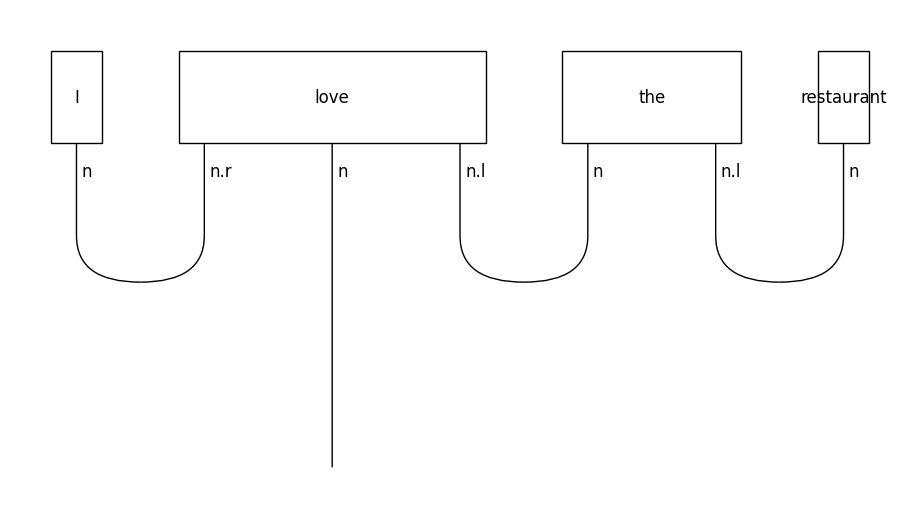

In [27]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

In object-based relative clauses the noun that follows the relative pronoun is the object of the sentence:

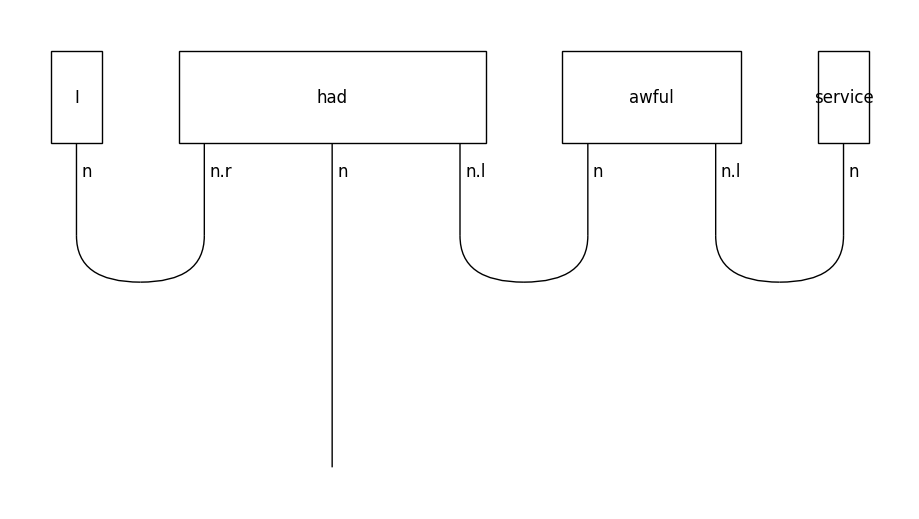

In [28]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

### Create circuits

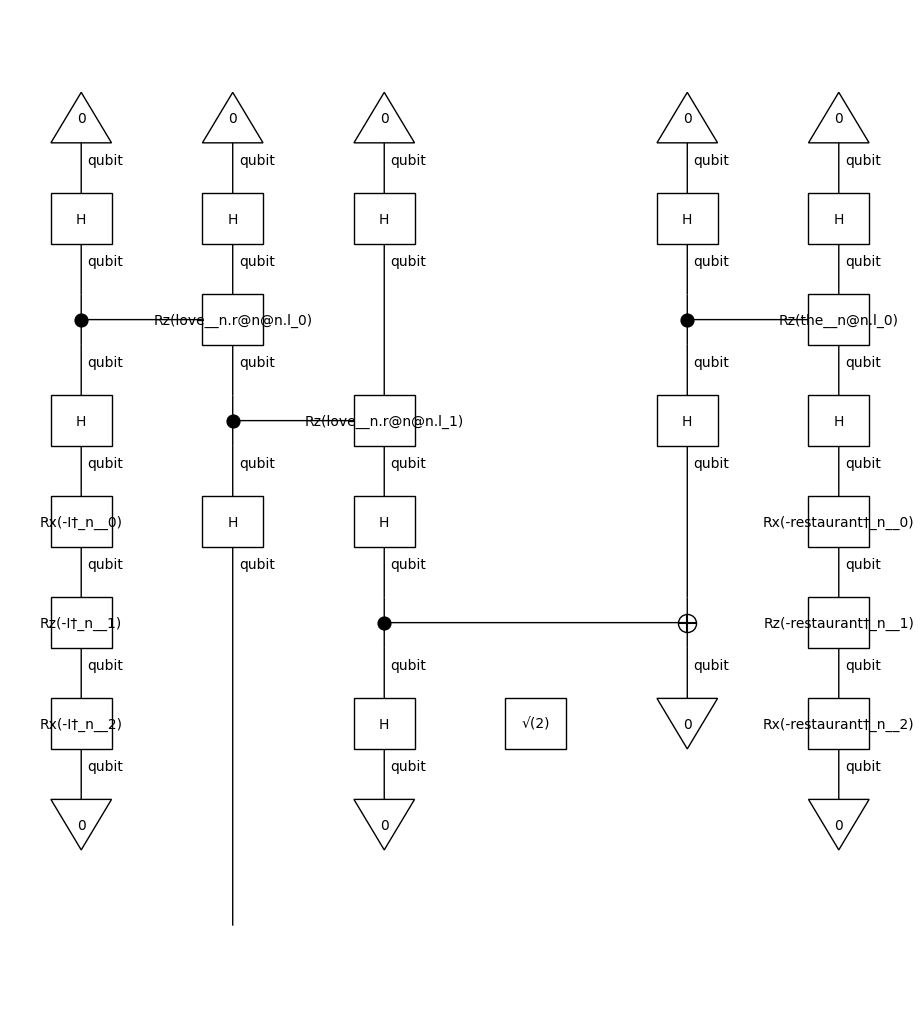

In [29]:
from lambeq import AtomicType, IQPAnsatz, RemoveCupsRewriter

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)
remove_cups = RemoveCupsRewriter()

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 10))

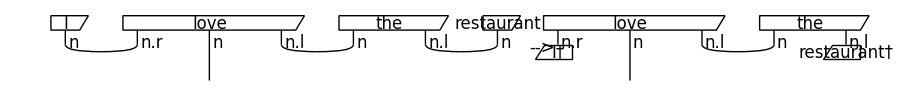

In [30]:
from lambeq.backend import draw_equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

draw_equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

## Training
### Instantiate the model

In [31]:
import qiskit_aer.noise as noise

# Define qubits
qubits = range(1)

# Define a noise model that applies uniformly to the given qubits
noise_model = noise.NoiseModel()
dep_err = noise.depolarizing_error(0.01, 1)
ro_err = noise.ReadoutError([[0.9, 0.1], [0.1, 0.9]])

# Add depolarizing error to single-qubit gates on each qubit
for i in qubits:
    noise_model.add_quantum_error(dep_err, ["u1", "u2", "u3"], [i])

# Add readout error for each qubit
for i in qubits:
    noise_model.add_readout_error(ro_err, qubits=[i])

In [32]:
from pytket.extensions.qiskit import AerBackend, IBMQEmulatorBackend, set_ibmq_config
from lambeq import TketModel, PennyLaneModel
import pennylane as qml
from qiskit_aer.noise import NoiseModel, depolarizing_error
all_circuits = train_circuits + val_circuits + test_circuits

backend_config = {'backend': 'qiskit.aer', 'noise_model':noise_model, 'shots':1000, 'probabilities':True}

# if no backend_config is provided, the default is used, which is the same as below
# backend_config = {'backend': 'default.qubit'}   # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

### Define loss and evaluation metric

In [33]:
import torch

def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

### Initialise trainer

In [34]:
from lambeq import PytorchTrainer

BATCH_SIZE = 10
EPOCHS = 100
LEARNING_RATE = 0.1
SEED = 42

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

### Create datasets

In [35]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

### Train

In [37]:
trainer.fit(train_dataset, val_dataset,
            minimize_criterion=False)

Epoch 1:    train/loss: 0.4046   valid/loss: 0.2960   train/acc: 0.5000   valid/acc: 0.5000
Epoch 2:    train/loss: 0.3541   valid/loss: 0.2407   train/acc: 0.6316   valid/acc: 0.5667
Epoch 3:    train/loss: 0.5044   valid/loss: 0.2141   train/acc: 0.6974   valid/acc: 0.7000
Epoch 4:    train/loss: 0.0898   valid/loss: 0.2485   train/acc: 0.7105   valid/acc: 0.6333
Epoch 5:    train/loss: 0.2336   valid/loss: 0.2373   train/acc: 0.7237   valid/acc: 0.6667
Epoch 6:    train/loss: 0.1900   valid/loss: 0.2112   train/acc: 0.8158   valid/acc: 0.7333
Epoch 7:    train/loss: 0.1346   valid/loss: 0.1783   train/acc: 0.7763   valid/acc: 0.6667
Epoch 8:    train/loss: 0.0968   valid/loss: 0.1735   train/acc: 0.7895   valid/acc: 0.7000
Epoch 9:    train/loss: 0.0908   valid/loss: 0.1412   train/acc: 0.8289   valid/acc: 0.8000
Epoch 10:   train/loss: 0.1446   valid/loss: 0.1240   train/acc: 0.8553   valid/acc: 0.8333
Epoch 11:   train/loss: 0.1220   valid/loss: 0.1390   train/acc: 0.8553   valid/

## Results

Finally, we visualise the results and evaluate the model on the test data.

Final test accuracy: 0.8333333333333334


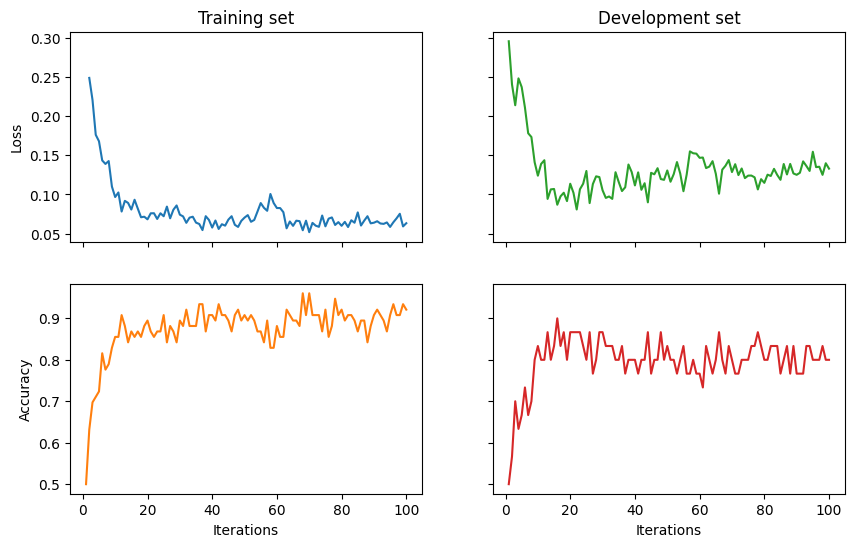

In [38]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

In [ ]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) ==
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

print('Final test accuracy: {}'.format(accuracy(test_circuits, test_labels)))


Final test accuracy: 0.8666666666666667
